# Exercise 1 (advanced)

## The SciPy Stack

**Python-based ecosystem of open-source software for mathematics, science, and engineering**

### The SciPy stack includes:
 * **IPython** Interactive python shell
 * **NumPy** N-dimensional array package and data format used in SciPy
 * **Matplotlib** Plotting and data visualization
 * **SciPy** Scientific computing: Integration, Optimization, Statistics, ...
 * **Pandas** Data structures & data analysis
 * **Sympy** Symbolic mathematics

In [473]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Visualization

In [435]:
def plot_data(X, y, classifier=None, show=True):
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], alpha=0.5, label='Signal')
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], alpha=0.5, label='Background')
    plt.legend(loc=1, bbox_to_anchor=(0.3, 1.2))
    if classifier is not None:
        supportX = np.arange(X[:, 0].min()-0.5, X[:, 0].max()+0.5, 0.05)
        supportY = np.arange(X[:, 1].min()-0.5, X[:, 1].max()+0.5, 0.05)
        GX, GY = np.meshgrid(supportX, supportY)
        GZ = classifier.predict(np.dstack([GX, GY]))
        plt.contourf(GX, GY, GZ, alpha=0.5, cmap='Greys', levels=np.linspace(GZ.min(), GZ.max(), 20))
        if hasattr(classifier, 'fisher'):
            plt.plot([-classifier.fisher[0]*3,classifier.fisher[0]*3],
                     [-classifier.fisher[1]*3,classifier.fisher[1]*3], 'k-',lw=4)
        if hasattr(classifier, 'root_node'):
            def draw(node, xmin, xmax, ymin, ymax):
                if 'purity' in node: return
                if node['feature'] == 0:
                    plt.vlines(x=node['value'], ymin=ymin, ymax=ymax, color='black')
                    draw(node['left'], xmin, node['value'], ymin, ymax)
                    draw(node['right'], node['value'], xmax, ymin, ymax)
                else:
                    plt.hlines(y=node['value'], xmin=xmin, xmax=xmax, color='black')
                    draw(node['left'], xmin, xmax, ymin, node['value'])
                    draw(node['right'], xmin, xmax, node['value'], ymax)
            draw(classifier.root_node, supportX.min(), supportX.max(), supportY.min(), supportY.max())
    if show:
        plt.show()
    
def plot_roc(X, y, classifier, show=True):
    p = classifier.predict(X)
    index = np.argsort(p)
    tpr = np.cumsum(y[index]) / y.sum()
    fpr = np.cumsum(1.0 - y[index]) / float(len(y) - y.sum())
    auc = np.trapz(fpr, tpr)
    plt.plot(tpr, fpr, lw=3, label='AUC {:3f}'.format(auc))
    plt.legend()
    if show:
        plt.show()

## Data

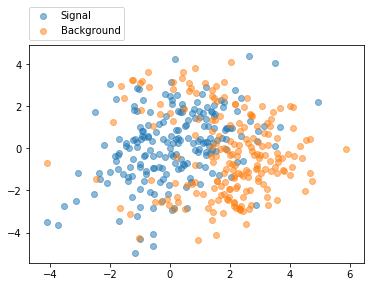

In [447]:
N = 200

def get_problem_1():
    signal = np.random.multivariate_normal([-1.0,-1.0],[[1.0,0.5],[0.5,1.0]],(N,))
    bckgrd = np.random.multivariate_normal([1.0,1.0],[[1.0,-0.5],[-0.5,1.0]],(N,))
    return signal, bckgrd

def get_problem_2():
    signal = np.random.multivariate_normal([0.0,0.0],[[2.0,1.0],[1.0,3.0]],(N,))
    r, phi = np.random.normal(3.0, size=(N,)), np.random.normal(0.0, 1, size=(N,))
    bckgrd = np.c_[r*np.cos(phi), r*np.sin(phi)]
    return signal, bckgrd

def get_data():
    X = np.vstack(get_problem_2())
    y = np.hstack([np.ones(N), np.zeros(N)])
    return X, y

X, y = get_data()
plot_data(X, y)

## Linear Discriminant Analysis

In [448]:
class LinearDiscriminantAnalysis(object):
    def fit(self, X, y):
        from numpy.linalg import inv
        numerator = np.mean(X[y == 1], axis=0) - np.mean(X[y == 0], axis=0)
        denominator = np.cov(X[y == 1].T) + np.cov(X[y == 0].T)
        self.fisher = np.dot(inv(denominator), numerator)
    def predict(self, X):
        return np.dot(X, fisher)

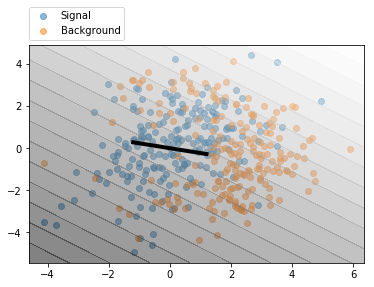

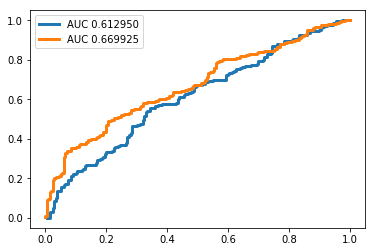

In [452]:
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)
plot_data(X, y, lda)
plot_roc(X, y, lda, show=False)
plot_roc(*get_data(), lda)

## Decision Tree

In [470]:
def get_neg_entropy(s, n):
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.where((s == 0) | (s==n), 0, s * np.log2(s/n) + (n-s) * np.log2((n-s)/n))

def get_separation_gain(sorted_ys):
    n = len(sorted_ys[0])
    s = sorted_ys[0].sum()
    sl = np.array([np.cumsum(sorted_y)[:-1] for sorted_y in sorted_ys])
    nl = np.array([np.arange(1, n) for sorted_y in sorted_ys])
    return get_neg_entropy(sl, nl) + get_neg_entropy(s - sl, n - nl)

class DecisionTree(object):
    def __init__(self, max_depth=None):
        self.root_node = {}
        self.max_depth = max_depth
        
    def fit(self, X, y):
        self._fit(X, y, 0, self.root_node)
    def _fit(self, X, y, depth, node):
        # Check if maximum depth is reached
        if self.max_depth is not None and depth == self.max_depth:
            return {'purity': y.mean()}
        # Calculate best cut based on the separation gain
        index = np.argsort(X.T)
        separation_gain = get_separation_gain(y[index])
        best_cut = np.unravel_index(np.argmax(separation_gain), separation_gain.shape)
        node['feature'] = best_cut[0]
        node['value'] = X[index[best_cut[0], best_cut[1]], best_cut[0]]
        node['separation_gain'] = separation_gain
        if best_cut[1] <= 1 or best_cut[1] >= len(index[best_cut[0]]) - 1:
            return {'purity': y.mean()}
        left = index[best_cut[0], :best_cut[1]]
        right = index[best_cut[0], best_cut[1]:]
        node['left'] = self._fit(X[left], y[left], depth+1, {})
        node['right'] = self._fit(X[right], y[right], depth+1, {})
        return node
    
    def predict(self, X):
        return np.apply_along_axis(self.predict_single, -1, X)

    def predict_single(self, x):
        node = self.root_node
        while 'purity' not in node:
            node = node['left'] if x[node['feature']] < node['value'] else node['right']
        return node['purity']

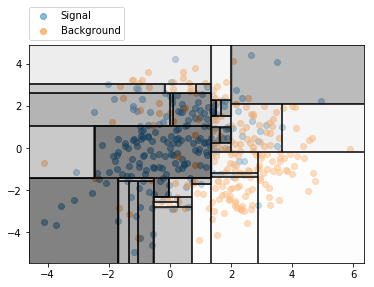

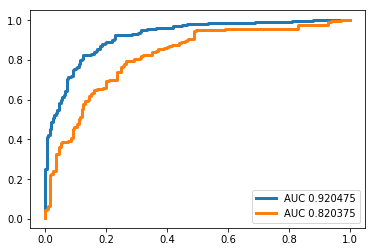

In [472]:
dt = DecisionTree(max_depth=10)
dt.fit(X, y)
plot_data(X, y, dt)
plot_roc(X, y, dt, show=False)
plot_roc(*get_data(), dt)

## Random Forest

In [467]:
import random

class RandomForest(object):
    def __init__(self, ntrees=100, sampling_rate=0.5, max_depth=3):
        self.ntrees = ntrees
        self.sampling_rate = sampling_rate
        self.max_depth = max_depth
        
    def fit(self, X, y):
        self.trees = []
        index = np.arange(len(X))
        for i in range(self.ntrees):
            index = random.sample(range(len(X)), int(len(X)*self.sampling_rate))
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X[index], y[index])
            self.trees.append(tree)
    
    def predict(self, X):
        return np.mean(np.array([tree.predict(X) for tree in self.trees]), axis=0)

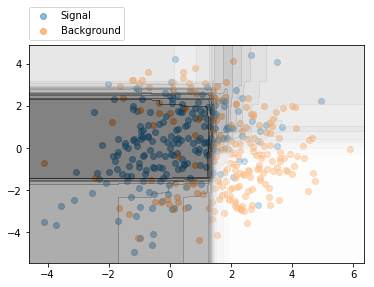

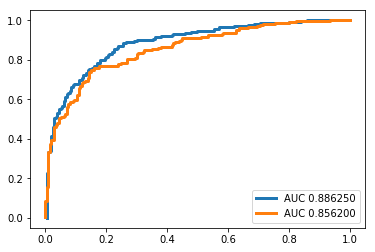

In [469]:
rf = RandomForest()
rf.fit(X, y)
plot_data(X, y, rf)
plot_roc(X, y, rf, show=False)
plot_roc(*get_data(), rf)

## Artificial Neural Network

In [455]:
class NeuralNetwork(object):
    def __init__(self, n_input, n_hidden):
        self.w_hi = np.random.normal(size=(n_input+1, n_hidden))
        self.w_oh = np.random.normal(size=n_hidden)

    def fit(self, X, y):
        # Append bias neuron
        X = np.apply_along_axis(lambda x: np.append(x, [1]), -1, X)
        # Scale y from [0, 1] to [-1, 1]
        y = 2 * y - 1
        for step in range(1, 1000):
            # Propagate input through hidden and output layer
            a_h = np.dot(X, self.w_hi)
            x_h = np.tanh(a_h)
            a_o = np.dot(x_h, self.w_oh)
            x_o = np.tanh(a_o)
            # Back-Propagate error signal
            d = lambda x: 4*np.cosh(x)**2/(np.cosh(2*x) + 1)**2
            e_o = d(a_o)*(x_o - y)
            e_h = d(a_h)*np.outer(e_o, self.w_oh)
            # Update weights
            self.w_oh -= 0.01/np.log(step+1) * np.dot(e_o.T, x_h)
            self.w_hi -= 0.01/np.log(step+1) * np.dot(X.T, e_h)

    def predict(self, X):
        # Append bias neuron
        X = np.apply_along_axis(lambda x: np.append(x, [1]), -1, X)
        # Propagate input trough hidden layer
        x_h = np.tanh(np.dot(X, self.w_hi))
        # Propagate output of hidden layer through output layer
        return np.tanh(np.dot(x_h, self.w_oh))

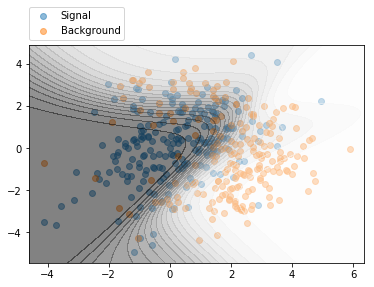

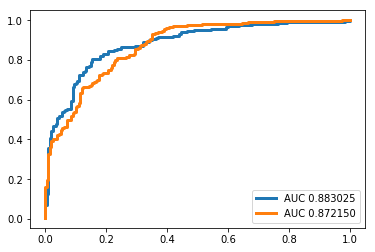

In [457]:
nn = NeuralNetwork(2, 4)
nn.fit(X, y)
plot_data(X, y, nn)
plot_roc(X, y, nn, show=False)
plot_roc(*get_data(), nn)